<a href="https://colab.research.google.com/github/1bensupriatma/GenerativeAI/blob/main/HW4/Problem1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Task 1

In [80]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
import tensorflow as tf
import random
from IPython import display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import (
    layers,
    models,
    callbacks,
    losses,
    utils,
    metrics,
    optimizers,
    utils,
)

In [2]:
!pip install patool
!apt-get install p7zip-full  # Make sure you have p7zip-full for better compatibility

import patoolib
import os
import requests

# Specify the path to the archive and the output directory
archive_path = "archive.zip"
output_dir = "dataset"

# Ensure the output directory exists
os.makedirs(output_dir, exist_ok=True)

# Download the file using requests in chunks to avoid memory issues
url = "https://www.kaggle.com/api/v1/datasets/download/jhoward/lsun_bedroom"  # Corrected URL

with requests.get(url, stream=True) as r:
    r.raise_for_status()  # Raise an exception for bad responses
    with open(archive_path, 'wb') as f:
        for chunk in r.iter_content(chunk_size=8192):
            f.write(chunk)

print(f"Dataset downloaded to: {archive_path}")

# Extract the archive using patoolib, trying different methods
try:
    # Try extracting as a zip file first
    patoolib.extract_archive(archive_path, outdir=output_dir, program="unzip")
except patoolib.util.PatoolError as e:
    print(f"Unzip failed: {e}")
    try:
        # If unzip fails, try 7z
        patoolib.extract_archive(archive_path, outdir=output_dir, program="7z")
    except patoolib.util.PatoolError as e:
        print(f"7z extraction failed: {e}")
        print("The downloaded file might be corrupted or not a standard archive format.")

print(f"Archive extracted to: {output_dir}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 2.1 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-8).
0 upgraded, 0 newly installed, 0 to remove and 0 not upgraded.


INFO patool: Extracting archive.zip ...
INFO:patool:Extracting archive.zip ...


Dataset downloaded to: archive.zip


INFO patool: running /usr/bin/unzip -- archive.zip -d dataset
INFO:patool:running /usr/bin/unzip -- archive.zip -d dataset
INFO patool: ... archive.zip extracted to `dataset'.
INFO:patool:... archive.zip extracted to `dataset'.


Archive extracted to: dataset


In [73]:
from google.colab import drive
IMAGE_SIZE = 64
CHANNELS = 3
BATCH_SIZE = 128
Z_DIM = 100
EPOCHS = 10
LOAD_MODEL = False
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.999
LEARNING_RATE = 0.0002
NOISE_PARAM = 0.1
os.listdir('/content')

['.config', 'dataset', 'drive', 'archive.zip', 'sample_data']

In [74]:
train_data =  tf.keras.preprocessing.image_dataset_from_directory(
    "dataset/",
    labels=None,
    color_mode="rgb",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    interpolation="bilinear",
)

Found 606250 files belonging to 1 classes.


In [75]:
def preprocess(img):
    """
    Normalize and reshape the images
    """
    img = (tf.cast(img, "float32") - 127.5) / 127.5
    return img

train = train_data.map(lambda x: preprocess(x))

In [76]:
def sample_batch(dataset):
  """
  Samples a batch of images from the dataset.
  """
  for images in dataset.take(1):
    return images

train_sample = sample_batch(train)

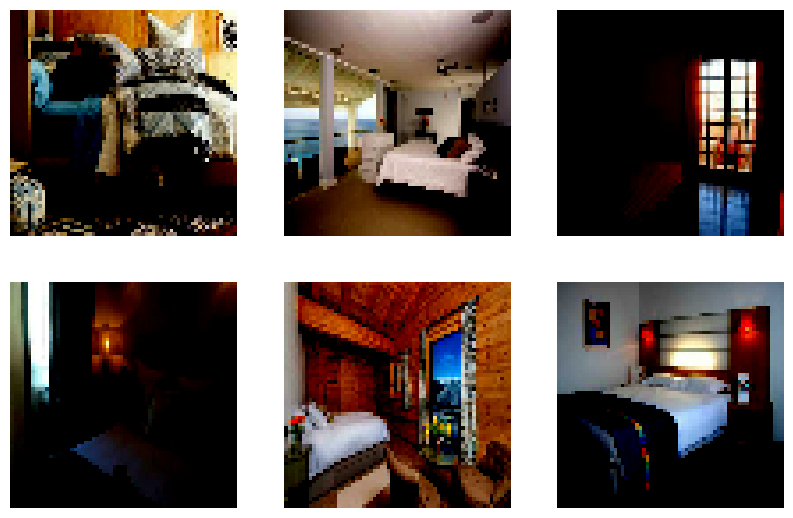

In [81]:
plt.figure(figsize=(10, 10))
for i in range(6):
    plt.subplot(3, 3, i + 1)
    plt.imshow(train_sample[i])
    plt.axis('off')
plt.show()

Task 2

In [82]:
discriminator_input = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
x = layers.Conv2D(64, kernel_size=4, strides=2, padding="same", use_bias=False)(
    discriminator_input
)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(
    128, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(
    256, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(
    512, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(
    1,
    kernel_size=4,
    strides=1,
    padding="valid",
    use_bias=False,
    activation="sigmoid",
)(x)
discriminator_output = layers.Flatten()(x)

discriminator = models.Model(discriminator_input, discriminator_output)
discriminator.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_11 (Conv2D)          (None, 32, 32, 64)        3072      
                                                                 
 leaky_re_lu_19 (LeakyReLU)  (None, 32, 32, 64)        0         
                                                                 
 dropout_10 (Dropout)        (None, 32, 32, 64)        0         
                                                                 
 conv2d_12 (Conv2D)          (None, 16, 16, 128)       131072    
                                                                 
 batch_normalization_12 (Ba  (None, 16, 16, 128)       512       
 tchNormalization)                                               
                                                             

In [83]:
generator_input = layers.Input(shape=(Z_DIM,))
x = layers.Reshape((1, 1, Z_DIM))(generator_input)
x = layers.Conv2DTranspose(
    512, kernel_size=4, strides=1, padding="valid", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(
    256, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(
    128, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(
    64, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
generator_output = layers.Conv2DTranspose(
    CHANNELS,
    kernel_size=4,
    strides=2,
    padding="same",
    use_bias=False,
    activation="tanh",
)(x)
generator = models.Model(generator_input, generator_output)
generator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 100)]             0         
                                                                 
 reshape_3 (Reshape)         (None, 1, 1, 100)         0         
                                                                 
 conv2d_transpose_9 (Conv2D  (None, 4, 4, 512)         819200    
 Transpose)                                                      
                                                                 
 batch_normalization_15 (Ba  (None, 4, 4, 512)         2048      
 tchNormalization)                                               
                                                                 
 leaky_re_lu_23 (LeakyReLU)  (None, 4, 4, 512)         0         
                                                                 
 conv2d_transpose_10 (Conv2  (None, 8, 8, 256)         2097

In [84]:
class DCGAN(models.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(DCGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer):
        super(DCGAN, self).compile()
        self.loss_fn = losses.BinaryCrossentropy()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_metric = metrics.Mean(name="d_loss")
        self.d_real_acc_metric = metrics.BinaryAccuracy(name="d_real_acc")
        self.d_fake_acc_metric = metrics.BinaryAccuracy(name="d_fake_acc")
        self.d_acc_metric = metrics.BinaryAccuracy(name="d_acc")
        self.g_loss_metric = metrics.Mean(name="g_loss")
        self.g_acc_metric = metrics.BinaryAccuracy(name="g_acc")

    @property
    def metrics(self):
        return [
            self.d_loss_metric,
            self.d_real_acc_metric,
            self.d_fake_acc_metric,
            self.d_acc_metric,
            self.g_loss_metric,
            self.g_acc_metric,
        ]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim)
        )

        # Train the discriminator on fake images
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = self.generator(
                random_latent_vectors, training=True
            )
            real_predictions = self.discriminator(real_images, training=True)
            fake_predictions = self.discriminator(
                generated_images, training=True
            )

            real_labels = tf.ones_like(real_predictions)
            real_noisy_labels = real_labels + NOISE_PARAM * tf.random.uniform(
                tf.shape(real_predictions)
            )
            fake_labels = tf.zeros_like(fake_predictions)
            fake_noisy_labels = fake_labels - NOISE_PARAM * tf.random.uniform(
                tf.shape(fake_predictions)
            )

            d_real_loss = self.loss_fn(real_noisy_labels, real_predictions)
            d_fake_loss = self.loss_fn(fake_noisy_labels, fake_predictions)
            d_loss = (d_real_loss + d_fake_loss) / 2.0

            g_loss = self.loss_fn(real_labels, fake_predictions)

        gradients_of_discriminator = disc_tape.gradient(
            d_loss, self.discriminator.trainable_variables
        )
        gradients_of_generator = gen_tape.gradient(
            g_loss, self.generator.trainable_variables
        )

        self.d_optimizer.apply_gradients(
            zip(gradients_of_discriminator, discriminator.trainable_variables)
        )
        self.g_optimizer.apply_gradients(
            zip(gradients_of_generator, generator.trainable_variables)
        )

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.d_real_acc_metric.update_state(real_labels, real_predictions)
        self.d_fake_acc_metric.update_state(fake_labels, fake_predictions)
        self.d_acc_metric.update_state(
            [real_labels, fake_labels], [real_predictions, fake_predictions]
        )
        self.g_loss_metric.update_state(g_loss)
        self.g_acc_metric.update_state(real_labels, fake_predictions)

        return {m.name: m.result() for m in self.metrics}

In [85]:
# Create a DCGAN
dcgan = DCGAN(
    discriminator=discriminator, generator=generator, latent_dim=Z_DIM
)


Task 3

In [86]:
dcgan.compile(
    d_optimizer=optimizers.Adam(
        learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2
    ),
    g_optimizer=optimizers.Adam(
        learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2
    ),
)

In [88]:
class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img, latent_dim):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(
            shape=(self.num_img, self.latent_dim)
        )
        generated_images = self.model.generator(random_latent_vectors)
        generated_images = generated_images * 127.5 + 127.5
        generated_images = generated_images.numpy()

In [96]:
num_files = len(list(train_data))
subset_size = num_files // 20
print(f"Number of files: {num_files}")
print(f"Subset size: {subset_size}")
train_subset = train_data.take(subset_size)

dcgan.fit(
    train_subset,
    epochs=50,
    callbacks=[
        ImageGenerator(num_img=5, latent_dim=Z_DIM),
    ],
)

Number of files: 4737
Subset size: 236
Epoch 1/50
236/236 [==============================] - 115s 488ms/step - d_loss: -0.7666 - d_real_acc: 1.0000 - d_fake_acc: 1.0000 - d_acc: 1.0000 - g_loss: 15.4240 - g_acc: 0.0000e+00
Epoch 2/50
236/236 [==============================] - 116s 490ms/step - d_loss: -0.7670 - d_real_acc: 1.0000 - d_fake_acc: 1.0000 - d_acc: 1.0000 - g_loss: 15.4235 - g_acc: 0.0000e+00
Epoch 3/50
236/236 [==============================] - 115s 488ms/step - d_loss: -0.7673 - d_real_acc: 1.0000 - d_fake_acc: 1.0000 - d_acc: 1.0000 - g_loss: 15.4242 - g_acc: 0.0000e+00
Epoch 4/50
236/236 [==============================] - 115s 487ms/step - d_loss: -0.7702 - d_real_acc: 1.0000 - d_fake_acc: 1.0000 - d_acc: 1.0000 - g_loss: 15.4241 - g_acc: 0.0000e+00
Epoch 5/50
236/236 [==============================] - 115s 488ms/step - d_loss: -0.7702 - d_real_acc: 1.0000 - d_fake_acc: 1.0000 - d_acc: 1.0000 - g_loss: 15.4229 - g_acc: 0.0000e+00
Epoch 6/50
236/236 [=====================

Task 4



1/1 [==============================] - 0s 50ms/step


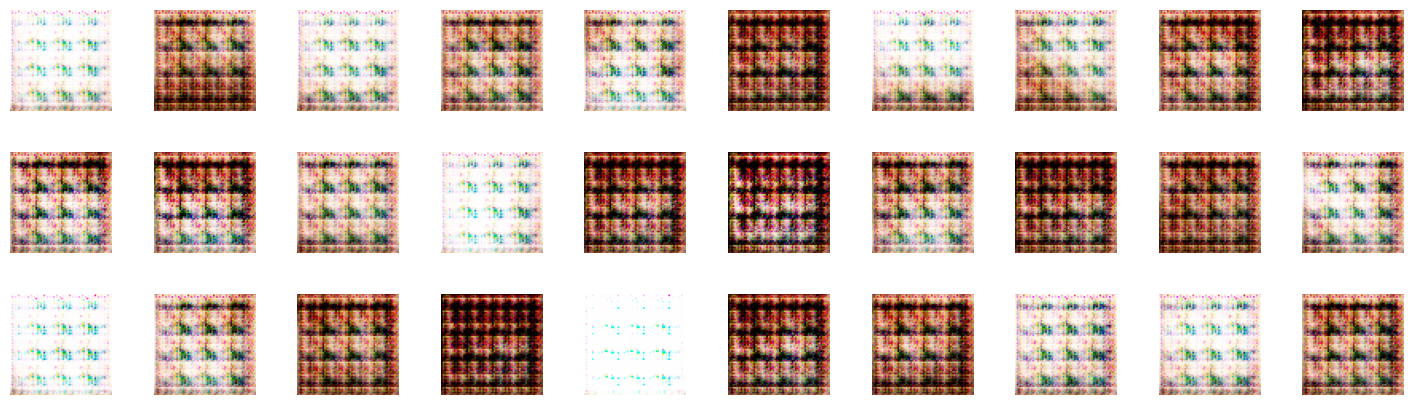

In [97]:
# Sample some points in the latent space, from the standard normal distribution
grid_width, grid_height = (10, 3)
z_sample = np.random.normal(size=(grid_width * grid_height, Z_DIM))
# Decode the sampled points
reconstructions = generator.predict(z_sample)
# Draw a plot of decoded images
fig = plt.figure(figsize=(18, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# Output the grid of faces
for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i, :, :], cmap="Greys")


1/1 [==============================] - 0s 40ms/step


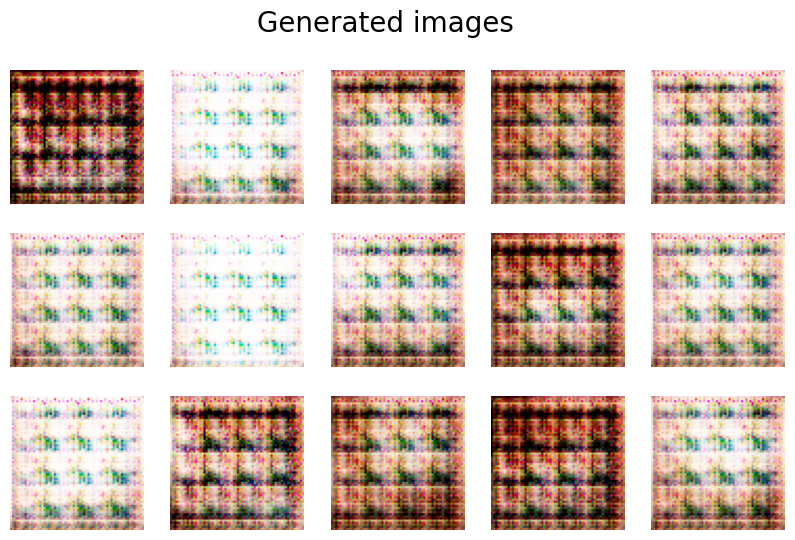

In [98]:
def compare_images(img1, img2):
    return np.mean(np.abs(img1 - img2))
all_data = []
for i in train.as_numpy_iterator():
    all_data.extend(i)
all_data = np.array(all_data)
r, c = 3, 5
fig, axs = plt.subplots(r, c, figsize=(10, 6))
fig.suptitle("Generated images", fontsize=20)

noise = np.random.normal(size=(r * c, Z_DIM))
gen_imgs = generator.predict(noise)

cnt = 0
for i in range(r):
    for j in range(c):
        axs[i, j].imshow(gen_imgs[cnt], cmap="gray_r")
        axs[i, j].axis("off")
        cnt += 1

plt.show()

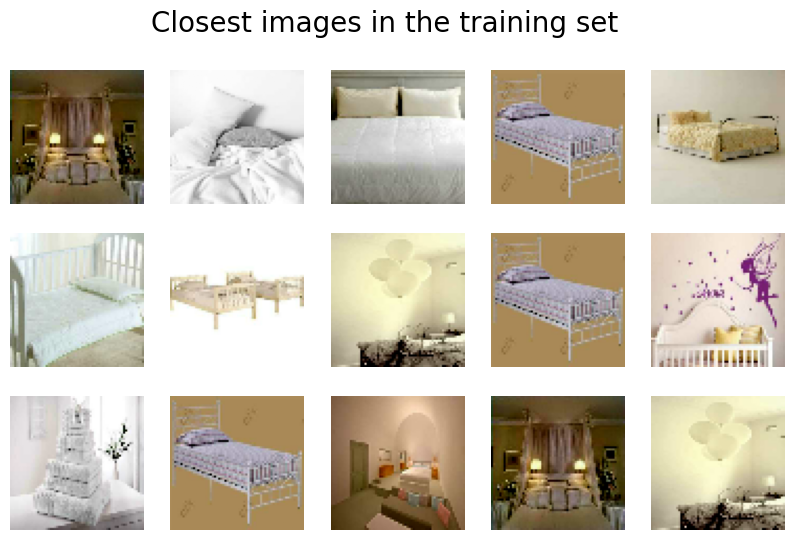

In [99]:
fig, axs = plt.subplots(r, c, figsize=(10, 6))
fig.suptitle("Closest images in the training set", fontsize=20)

cnt = 0
for i in range(r):
    for j in range(c):
        c_diff = 99999
        c_img = None
        for k_idx, k in enumerate(all_data):
            diff = compare_images(gen_imgs[cnt], k)
            if diff < c_diff:
                c_img = np.copy(k)
                c_diff = diff
        axs[i, j].imshow(c_img, cmap="gray_r")
        axs[i, j].axis("off")
        cnt += 1

plt.show()


Discuss the trade-off between generating high-quality images and maintaining diversity in the output. Are the generated images too similar, or does the model capture a wide range of bedroom styles?
**The tradeoff would be that if they are high image quality, they will lack in diversity and vice versa. I have tried using a smaller epoch run, and this only resulted in about 4 images being repeatedly generated**


Consider on potential enhancements to the model architecture or training process. Would experimenting with different hyperparameters or batch sizes yield better results? **With the higher batch sizes, I feel like the runtime will be way longer than it already is, but we will yield better results.**

What are the practical applications for this type of generative model?
**The practical applications of this madel would be for visualizations of different types of artwork like paintings or maybe interior design. Ifeel like this also could be applied into stuff for virtual reality and gaming aspects. **